# setup


In [61]:
import gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import warnings
import time

from IPython.display import clear_output

import tensorflow as tf
from keras import models
from keras import layers
from keras.optimizers import Adam
from collections import deque
import matplotlib.pyplot as plt

import pickle

In [51]:
def plot_rewards(agent):
    plt.title(agent.name)
    plt.xlabel('Episode')
    plt.ylabel('Reward (Episode length)')
    plt.plot(agent.episode_rewards, label='original')
    plt.plot(pd.Series(agent.episode_rewards).rolling(window=10).mean(), label='average')
    plt.show()


In [78]:
# Set the Training parameters

# set true, to get printed out the trainings progress
plot = True
# Set number of stepts an agent can take, before the environment is reset, 
max_steps = 500
# Set total of training episodes (the number of trials a agent can do)    
total_episodes = 200

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.9} # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 1,
    'min_epsilon': 0.0,
    'decay_rate': 0.008} # smaller decay rate, more exploration


In [54]:
def pickle_data(agentname, qvalues, rewards):
    if isinstance(qvalues, tf.keras.Model):
      qvalues.save('{}_network.h5'.format(agentname))
    else:
      with open('{}_qvalues.pickle'.format(agentname), 'wb') as handle:
        pickle.dump(qvalues, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('{}_rewards.pickle'.format(agentname), 'wb') as handle:
      pickle.dump(rewards, handle, protocol=pickle.HIGHEST_PROTOCOL)

# discrete environment init

In [55]:
class DiscretizedObservationWrapper(gym.ObservationWrapper):
    """This wrapper converts a Box observation into a single integer.
    """
    def __init__(self, env, n_bins):
        super().__init__(env)
        assert isinstance(env.observation_space, gym.spaces.Box)

        low = self.observation_space.low
        high = self.observation_space.high

        self.n_bins = n_bins
        self.val_bins = [np.linspace(l, h, n_bins + 1) for l, h in
                         zip(low.flatten(), high.flatten())]
        self.observation_space = gym.spaces.Discrete(n_bins ** low.flatten().shape[0])

    def _convert_to_one_number(self, digits):
        return sum([d * ((self.n_bins + 1) ** i) for i, d in enumerate(digits)])

    def observation(self, observation):
        digits = [np.digitize([x], bins)[0]
                  for x, bins in zip(observation.flatten(), self.val_bins)]
        return self._convert_to_one_number(digits)

In [56]:
env = gym.make('CartPole-v1')
env = DiscretizedObservationWrapper(
    env, 
    n_bins=12
)

# random

In [64]:
class RandomAgent(object):
    """
    Implementation of a Q-learning Algorithm
    """
    def __init__(self, env):
        self.env = env
        self.name = 'Random Sampling'

    def random_sampling(self, plot = False, max_steps = 10, total_episodes = 1000):
        """
        implementation of the q-learning algorithm, here the q-table values are calculated
        Args:
          plot (boolean): set true, to get trainings progress 
          max_steps (int): number of stepts an agent can take, before the environment is reset 
          total_episodes (int): total of training episodes (the number of trials a agent can do)          
        """

        # create placeholders to store the results
        self.episode_rewards = np.zeros(total_episodes) 
        self.episode_epsilon = np.zeros(total_episodes)
        self.episode_last_state = np.zeros(total_episodes)
        
        start = time.time()
        # loop over all episodes
        for episode_i in range(total_episodes):
            # initalize the environment
            state = self.env.reset()
            
            # for each episode loop over the max number of steps that are possible
            for step in range(max_steps):
                
                # self.env.render()
                
                action = env.action_space.sample()
                
                # take an action and observe the outcome state (new_state), reward and stopping criterion
                state, reward, done, _ = self.env.step(action)
                self.episode_rewards[episode_i] += reward            
#                 self.result = np.dstack((self.result, self.qtable))

                # check stopping criterion
                if done == True:
                    break
            
#             self.episode_rewards[episode_i] /= step # average the reward
            self.episode_last_state[episode_i] = state # update last state
            
            if episode_i%10==0 and plot:
#             clear_output(wait=True)
                print('episode {} elapsed time [sec]: {}'.format(episode_i, round( (time.time() - start), 2)))
        plot_rewards(self)


episode 0 elapsed time [sec]: 0.0
episode 10 elapsed time [sec]: 0.03
episode 20 elapsed time [sec]: 0.05
episode 30 elapsed time [sec]: 0.06
episode 40 elapsed time [sec]: 0.08
episode 50 elapsed time [sec]: 0.09
episode 60 elapsed time [sec]: 0.11
episode 70 elapsed time [sec]: 0.13
episode 80 elapsed time [sec]: 0.14
episode 90 elapsed time [sec]: 0.16


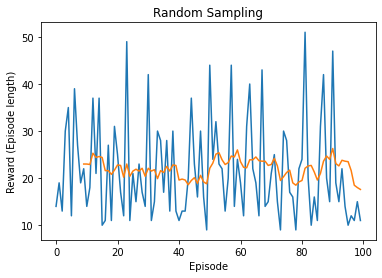

In [65]:
def r():
    plot = True
    max_steps = 200
    total_episodes = 100

    random_Agent = RandomAgent(env)
    try:
        random_Agent.random_sampling(plot = plot, max_steps = max_steps, total_episodes = total_episodes)
        env.close()
    except KeyboardInterrupt:
        env.close()
        print('closed env...')
    
r()

# sarsa

In [66]:
class SarsaAgent(object):
    """
    Implementation of a Q-learning Algorithm
    """
    def __init__(self, env, name, state_size, action_size, learning_parameters, exploration_parameters): 
        """
        initialize the Q-learning agent
        Args:
          name (str): set the name of the Q-Agent
          state_size (int): ..
          action_size (int): ..
          learning_parameters (dict): 
          exploration_parameters (dict):
        """
        self.name = name
                
        # init the Q-table
        self.qtable = np.zeros((state_size, action_size))
        self.result = np.zeros((state_size, action_size))
        
        # learning parameters
        self.learning_rate = learning_parameters['learning_rate']
        self.gamma = learning_parameters['gamma']
        
        # exploration parameters
        self.epsilon = exploration_parameters['epsilon']      
        self.max_epsilon = exploration_parameters['max_epsilon']
        self.min_epsilon = exploration_parameters['min_epsilon']
        self.decay_rate = exploration_parameters['decay_rate']    
        
        self.env = env
    
    
    def sarsa_learning(self, plot = False, max_steps = 10, total_episodes = 1000):
        """
        implementation of the q-learning algorithm, here the q-table values are calculated
        Args:
          plot (boolean): set true, to get trainings progress 
          max_steps (int): number of stepts an agent can take, before the environment is reset 
          total_episodes (int): total of training episodes (the number of trials a agent can do)          
        """

        # create placeholders to store the results
        self.episode_rewards = np.zeros(total_episodes) 
        self.episode_rewards_avg = np.zeros(total_episodes) 
        self.episode_epsilon = np.zeros(total_episodes)
        self.episode_last_state = np.zeros(total_episodes)
        
        start = time.time()
        # loop over all episodes
        for episode_i in range(total_episodes):
            # initalize the environment
            state = self.env.reset()
            # get action, e-greedy
            action = self.get_action(state)
            start = time.time()
            
            # for each episode loop over the max number of steps that are possible
            for step in range(max_steps):   
                # self.env.render()
                               
                # take an action and observe the outcome state (new_state), reward and stopping criterion
                new_state, reward, done, _ = self.env.step(action)
                
                # get action, e-greedy
                new_action = self.get_action(state)
                
                self.qtable[state, action] = self.update_qtable(state, action, new_state, new_action, reward, done)
                
                state = new_state
                action = new_action
                
                self.episode_rewards[episode_i] += reward            
                self.episode_rewards_avg[episode_i] += reward            
                self.result = np.dstack((self.result, self.qtable))

                # check stopping criterion
                if done == True:
                    break
            
#             self.episode_rewards_avg[episode_i] /= step # average the reward
            self.episode_last_state[episode_i] = state # average the reward
            
            # reduce epsilon, for exploration-exploitation tradeoff
            self.update_epsilon(episode_i)
            
#             if episode_i % 100 == 0 and plot:
            if plot and episode_i%10==0:
                print('episode {} elapsed time [sec]: {}'.format(episode_i, round((time.time() - start), 2)))     
        
        plot_rewards(self)
            
    def update_qtable(self, state, action, new_state, new_action, reward, done):
        """
        update the q-table: Q(s,a) = Q(s,a) + lr  * [R(s,a) + gamma * max Q(s',a') - Q (s,a)]
        Args:
          state (int): current state of the environment
          new_state (int): new state of the environment
          action (int): current action taken by agent
          reward (int): current reward received from env
          done (boolean): variable indicating if env is done
        Returns:
          qtable (array): the qtable containing a value for every state (y-axis) and action (x-axis) 
        """
#         print(state, action)
        return self.qtable[state,action] + self.learning_rate * \
                          (reward + self.gamma * self.qtable[new_state, new_action] * (1- done) - self.qtable[state, action])
    
    
    def update_epsilon(self, episode):
        """
        reduce epsilon, exponential decay
        Args:
          episode (int): number of episode
        """
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate*episode)

        
    def get_action(self, state):
        """
        select action e-greedy
        Args:
          state (int): current state of the environment/agent
        Returns:
          action (int): action that the agent will take in the next step
        """
        if random.uniform(0,1) >= self.epsilon:
            # exploitation, max value for given state
            action = np.argmax(self.qtable[state, :])
        else:
            # exploration, random choice
            action = self.env.action_space.sample()
        return action
    
    def play(self, total_episodes=100):
        self.episode_rewards = np.zeros(total_episodes) 
#         self.episode_epsilon = np.zeros(total_episodes)
#         self.episode_last_state = np.zeros(total_episodes)
        
        for episode_i in range(total_episodes):
            step = 0
            start = time.time()
        
            # self.env.render()
            state = self.env.reset()
            action = self.get_action(state)
            new_state, reward, done, _ = self.env.step(action)
            
            while not done:
                # self.env.render()
                action = self.get_action(state)
                new_state, reward, done, _ = self.env.step(action)

                state = new_state
                self.episode_rewards[episode_i] += reward   
#                 print(reward)
                step += 1
                
                if done == True:
                    break
        
#             self.episode_rewards[episode_i] /= step # average the reward
#             self.episode_last_state[episode_i] = state # average the reward
            if plot and episode_i%10==0:
                print('episode {} reward {} elapsed time [sec] {}'.format(episode_i, self.episode_rewards[episode_i], round((time.time()-start), 2)))
            
            if 100 <= step and 195 <= self.episode_rewards[episode_i]:
                print('solved!')
        plot_rewards(self)
        

episode 0 elapsed time [sec]: 0.04
episode 10 elapsed time [sec]: 0.67
episode 20 elapsed time [sec]: 0.38
episode 30 elapsed time [sec]: 0.47
episode 40 elapsed time [sec]: 0.8
episode 50 elapsed time [sec]: 3.73
episode 60 elapsed time [sec]: 1.66
episode 70 elapsed time [sec]: 1.38
episode 80 elapsed time [sec]: 3.05
episode 90 elapsed time [sec]: 2.11
episode 100 elapsed time [sec]: 9.04
episode 110 elapsed time [sec]: 5.71
episode 120 elapsed time [sec]: 3.08
episode 130 elapsed time [sec]: 2.21
episode 140 elapsed time [sec]: 6.84
episode 150 elapsed time [sec]: 3.68
episode 160 elapsed time [sec]: 3.53
episode 170 elapsed time [sec]: 2.86
episode 180 elapsed time [sec]: 3.0
episode 190 elapsed time [sec]: 4.18


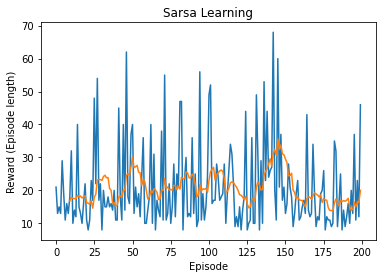

done
episode 0 reward 35.0 elapsed time [sec] 0.0


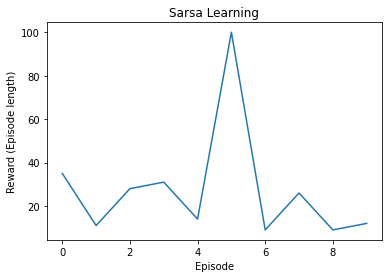

In [67]:
# def s():
env = gym.make('CartPole-v1')
env = DiscretizedObservationWrapper(
    env, 
    n_bins=12
)
# sarsa agent II
# avoid slipping in on the chain
env.env.slip = 0

name = 'Sarsa Learning'
action_size = env.action_space.n
state_size = env.observation_space.n


sarsa_agent = SarsaAgent(env, name, state_size, action_size, learning_parameters, exploration_parameters)
try:
    sarsa_agent.sarsa_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)
    env.close()
    print('done')
except KeyboardInterrupt:
    env.close()
    print('interrupted. closed env...')
    
pickle_data('sarsa', sarsa_agent.qtable, sarsa_agent.episode_rewards)

# input('press to continue to play()')

# sarsa agent III
try:
    sarsa_agent.play(10)
    env.close()
except KeyboardInterrupt:
    env.close()
    print('closed env...')
    
# s()

# q learning

In [68]:
class QAgent(object):
    """
    Implementation of a Q-learning Algorithm
    """
    def __init__(self, env, name, state_size, action_size, learning_parameters, exploration_parameters): 
        """
        initialize the Q-learning agent
        Args:
          name (str): set the name of the Q-Agent
          state_size (int): ..
          action_size (int): ..
          learning_parameters (dict): 
          exploration_parameters (dict):
        """
        self.name = name
                
        # init the Q-table
        self.qtable = np.zeros((state_size, action_size))
        self.result = np.zeros((state_size, action_size))
        
        # learning parameters
        self.learning_rate = learning_parameters['learning_rate']
        self.gamma = learning_parameters['gamma']
        
        # exploration parameters
        self.epsilon = exploration_parameters['epsilon']      
        self.max_epsilon = exploration_parameters['max_epsilon']
        self.min_epsilon = exploration_parameters['min_epsilon']
        self.decay_rate = exploration_parameters['decay_rate']    
        
        self.env = env
    
    
    def q_learning(self, plot = False, max_steps = 10, total_episodes = 1000):
        """
        implementation of the q-learning algorithm, here the q-table values are calculated
        Args:
          plot (boolean): set true, to get trainings progress 
          max_steps (int): number of stepts an agent can take, before the environment is reset 
          total_episodes (int): total of training episodes (the number of trials a agent can do)          
        """

        # create placeholders to store the results
        self.episode_rewards = np.zeros(total_episodes) 
        self.episode_epsilon = np.zeros(total_episodes)
        self.episode_last_state = np.zeros(total_episodes)
        
        # loop over all episodes
        for episode_i in range(total_episodes):
            start = time.time()
            # initalize the environment
            state = self.env.reset()
            
            # for each episode loop over the max number of steps that are possible
            for step in range(max_steps):   
                # self.env.render()
                # get action, e-greedy
                action = self.get_action(state)
                               
                # take an action and observe the outcome state (new_state), reward and stopping criterion
                new_state, reward, done, _ = self.env.step(action)

                self.qtable[state, action] = self.update_qtable(state, new_state, action, reward, done)
                state = new_state
                self.episode_rewards[episode_i] += reward            
                self.result = np.dstack((self.result, self.qtable))

                # check stopping criterion
                if done == True:
                    break
            
#             self.episode_rewards[episode_i] /= step # average the reward
#             self.episode_last_state[episode_i] = state # average the reward
            
            # reduce epsilon, for exploration-exploitation tradeoff
            self.update_epsilon(episode_i)
            
            if plot and episode_i%10==0:
                print('episode {} elapsed time [sec]: {}'.format(episode_i, round((time.time() - start), 2)))
                
        # plt.title(self.name)
        # plt.xlabel('Episode')
        # plt.ylabel('Reward (Episode length)')
        # plt.plot(self.episode_rewards)
        # plt.show()
        plot_rewards(self)

            
    def update_qtable(self, state, new_state, action, reward, done):
        """
        update the q-table: Q(s,a) = Q(s,a) + lr  * [R(s,a) + gamma * max Q(s',a') - Q (s,a)]
        Args:
          state (int): current state of the environment
          new_state (int): new state of the environment
          action (int): current action taken by agent
          reward (int): current reward received from env
          done (boolean): variable indicating if env is done
        Returns:
          qtable (array): the qtable containing a value for every state (y-axis) and action (x-axis) 
        """
#         print(state, action)
        return self.qtable[state,action] + self.learning_rate * \
                          (reward + self.gamma * np.max(self.qtable[new_state, :]) * (1- done) - self.qtable[state, action])
    
    
    def update_epsilon(self, episode):
        """
        reduce epsilon, exponential decay
        Args:
          episode (int): number of episode
        """
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate*episode)

        
    def get_action(self, state):
        """
        select action e-greedy
        Args:
          state (int): current state of the environment/agent
        Returns:
          action (int): action that the agent will take in the next step
        """
        if random.uniform(0,1) >= self.epsilon:
            # exploitation, max value for given state
            action = np.argmax(self.qtable[state, :])
        else:
            # exploration, random choice
            action = self.env.action_space.sample()
        return action
    
    def play(self, total_episodes=100):
        self.episode_rewards = np.zeros(total_episodes) 
#         self.episode_epsilon = np.zeros(total_episodes)
#         self.episode_last_state = np.zeros(total_episodes)
        
        for episode_i in range(total_episodes):
            step = 0
            start = time.time()
        
            # self.env.render()
            state = self.env.reset()
            action = self.get_action(state)
            new_state, reward, done, _ = self.env.step(action)
            
            while not done:
                # self.env.render()
                action = self.get_action(state)
                new_state, reward, done, _ = self.env.step(action)

                state = new_state
                self.episode_rewards[episode_i] += reward   
#                 print(reward)
                step += 1
                
                if done == True:
                    break
            
#             self.episode_rewards[episode_i] /= step # average the reward
#             self.episode_last_state[episode_i] = state # average the reward
            
            if plot:
                print('episode {} reward {} elapsed time [sec]: {}'.format(episode_i, self.episode_rewards[episode_i], round((time.time() - start), 2)))
            if 100 <= step and 195 <= self.episode_rewards[episode_i]:
                print('solved!')
        
        plot_rewards(self)
          

episode 0 elapsed time [sec]: 0.03
episode 1 elapsed time [sec]: 0.09
episode 2 elapsed time [sec]: 0.06
episode 3 elapsed time [sec]: 0.15
episode 4 elapsed time [sec]: 0.59
episode 5 elapsed time [sec]: 0.18
episode 6 elapsed time [sec]: 0.3
episode 7 elapsed time [sec]: 0.93
episode 8 elapsed time [sec]: 0.33
episode 9 elapsed time [sec]: 0.33
episode 10 elapsed time [sec]: 0.41
episode 11 elapsed time [sec]: 0.9
episode 12 elapsed time [sec]: 0.36
episode 13 elapsed time [sec]: 2.09
episode 14 elapsed time [sec]: 0.57
episode 15 elapsed time [sec]: 0.47
episode 16 elapsed time [sec]: 1.88
episode 17 elapsed time [sec]: 0.63
episode 18 elapsed time [sec]: 1.11
episode 19 elapsed time [sec]: 1.01
episode 20 elapsed time [sec]: 0.68
episode 21 elapsed time [sec]: 0.66
episode 22 elapsed time [sec]: 1.03
episode 23 elapsed time [sec]: 0.91
episode 24 elapsed time [sec]: 0.74
episode 25 elapsed time [sec]: 0.69
episode 26 elapsed time [sec]: 0.83
episode 27 elapsed time [sec]: 0.61
epis

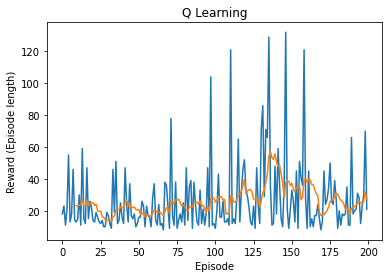

done
episode 0 reward 14.0 elapsed time [sec]: 0.01
episode 1 reward 35.0 elapsed time [sec]: 0.0
episode 2 reward 60.0 elapsed time [sec]: 0.01
episode 3 reward 12.0 elapsed time [sec]: 0.0
episode 4 reward 40.0 elapsed time [sec]: 0.0
episode 5 reward 76.0 elapsed time [sec]: 0.01
episode 6 reward 32.0 elapsed time [sec]: 0.0
episode 7 reward 28.0 elapsed time [sec]: 0.0
episode 8 reward 12.0 elapsed time [sec]: 0.0
episode 9 reward 23.0 elapsed time [sec]: 0.0


In [69]:
# def q():

# q agent II
# avoid slipping in on the chain
env.env.slip = 0

name = 'Q Learning'
action_size = env.action_space.n
state_size = env.observation_space.n

q_agent = QAgent(env, name, state_size, action_size, learning_parameters, exploration_parameters)
try:
    q_agent.q_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)
    env.close()
    print('done')
except KeyboardInterrupt:
    env.close()
    print('interrupted. closed env...')

pickle_data('qlearning', q_agent.qtable, q_agent.episode_rewards)

# input('press to continue to play()')

# q agent III
try:
    q_agent.play(10)
    env.close()
except KeyboardInterrupt:
    env.close()
    print('closed env...')
    
# q()

# continouous environment init

In [70]:
env = gym.make('CartPole-v1')

# deep q learning

In [95]:
class DQ_Agent:
    def __init__(self, env, name, learning_parameters, exploration_parameters):
        self.env = env
        self.name = name
        self.gamma = learning_parameters['gamma']
        self.epsilon = exploration_parameters['epsilon']
        self.decay_rate = exploration_parameters['decay_rate']
        self.max_epsilon = exploration_parameters['max_epsilon']
        self.min_epsilon = exploration_parameters['min_epsilon']
        self.learning_rate = learning_parameters['learning_rate']
        self.replay_memory = deque(maxlen=learning_parameters['memory_capacity'])
        
        self.q_network = self.build_network(self.learning_rate, self.env.observation_space.shape, self.env.action_space.n)
        self.minibatch_size = 256 #128

    def build_network(self, lr, input_shape, output_shape):
        model = models.Sequential()
        model.add(layers.Dense(32, activation='relu', input_shape=input_shape))
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dense(output_shape ,activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=lr))

        return model

    def get_action(self, state):
        if random.uniform(0,1) >= self.epsilon:
            action = np.argmax(self.q_network.predict(state)[0])
        else:
            action = self.env.action_space.sample()
        return action

    def update_qvalue(self, reward, new_targets_i, done):
        # return reward + (1-done) * self.gamma * max(new_targets_i) ###
        # return reward + (1-done) * self.gamma * max(new_targets_i) + done * -10 ###
        if done:
            # return -reward
            return -100
        else:
            return reward + self.gamma * max(new_targets_i)

    def update_epsilon(self, episode):
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate*episode)
    
    def dq_training(self):
        minibatches = random.sample(self.replay_memory, self.minibatch_size)

        states = []
        new_states=[]

        for transition in minibatches:
            # state, action, reward, new_state, done = transition
            state, _, _, new_state, _ = transition

            states.append(state)
            new_states.append(new_state)

        states = np.array(states).reshape(self.minibatch_size, self.env.observation_space.shape[0])
        new_states = np.array(new_states).reshape(self.minibatch_size, self.env.observation_space.shape[0])

        targets = self.q_network.predict(states)
        new_targets = self.q_network.predict(states)

        for i, transition in enumerate(minibatches):
            _, action, reward, _, done = transition
            targets[i][action] = self.update_qvalue(reward, new_targets[i], done)

        self.q_network.fit(states, targets, epochs=1, verbose=0)

    def dq_learning(self, plot = False, max_steps = 10, total_episodes = 400):
        self.episode_rewards = np.zeros(total_episodes) 
        self.episode_epsilon = np.zeros(total_episodes)
        self.episode_last_state = np.zeros(total_episodes)
        
        start = time.time()
        
        for episode_i in range(total_episodes):
            state = self.env.reset()
            state = state.reshape(1, self.env.observation_space.shape[0]) # preprocessing
            start = time.time()
            for step in range(max_steps):
                # self.env.render()

                action = self.get_action(state)
                new_state, reward, done, _ = self.env.step(action)
                new_state = new_state.reshape(1, self.env.observation_space.shape[0]) # preprocessing

                self.replay_memory.append([state, action, reward, new_state, done])
                
                if self.minibatch_size <= len(self.replay_memory):
                    self.dq_training()

                self.episode_rewards[episode_i] += reward            

                state = new_state

                if done == True:
                    break

#             self.episode_rewards[episode_i] /= step # average the reward
            self.update_epsilon(episode_i)
            
            if episode_i%10==0 and plot:
                print("ep{} epsilon = {} r = {} t = {}".format(
                    episode_i, round(self.epsilon,3), round(self.episode_rewards[episode_i]), round((time.time()-start),2)))

        plot_rewards(self)
                
    def play(self, total_episodes=100):
        self.episode_rewards = np.zeros(total_episodes) 
#         self.episode_epsilon = np.zeros(total_episodes)
#         self.episode_last_state = np.zeros(total_episodes)
        
        for episode_i in range(total_episodes):
            step = 0
            start = time.time()
        
            # self.env.render()
            state = self.env.reset()
            state = state.reshape(1, self.env.observation_space.shape[0]) # preprocessing
            action = np.argmax(self.q_network.predict(state))
            new_state, reward, done, _ = self.env.step(action)
            
            while not done:
                # self.env.render()
                action = np.argmax(self.q_network.predict(state))
                new_state, reward, done, _ = self.env.step(action)

                state = new_state
                state = state.reshape(1, self.env.observation_space.shape[0]) # preprocessing
                
                self.episode_rewards[episode_i] += reward   
#                 print(reward)
                step += 1
                
                if done == True:
                    break
            
#             self.episode_rewards[episode_i] /= step # average the reward
#             self.episode_last_state[episode_i] = state # average the reward
            
            print('ep{} r = {} t = {}'.format(
                episode_i, self.episode_rewards[episode_i], round( (time.time() - start), 2)))
            
            if plot:
                print('episode {} reward {} elapsed time [sec]: {}'.format(episode_i, self.episode_rewards[episode_i], round((time.time() - start), 2)))
            if 100 <= step and 195 <= self.episode_rewards[episode_i]:
                print('solved!')
        plot_rewards(self)

        

## y = reward + (1-done) * gamma * max(Q(s', a'; theta))

ep0 epsilon = 1.0 r = 20 t = 0.0
ep10 epsilon = 0.01 r = 8 t = 0.34
ep20 epsilon = 0.01 r = 10 t = 2.04
ep30 epsilon = 0.01 r = 9 t = 1.67
ep40 epsilon = 0.01 r = 10 t = 1.75
ep50 epsilon = 0.01 r = 9 t = 1.61
ep60 epsilon = 0.01 r = 10 t = 1.84
ep70 epsilon = 0.01 r = 10 t = 1.76
ep80 epsilon = 0.01 r = 8 t = 1.4
ep90 epsilon = 0.01 r = 10 t = 1.77
ep100 epsilon = 0.01 r = 8 t = 1.33
ep110 epsilon = 0.01 r = 11 t = 2.23
ep120 epsilon = 0.01 r = 8 t = 1.38
ep130 epsilon = 0.01 r = 10 t = 1.82
ep140 epsilon = 0.01 r = 10 t = 1.79
ep150 epsilon = 0.01 r = 10 t = 1.8
ep160 epsilon = 0.01 r = 10 t = 1.78
ep170 epsilon = 0.01 r = 10 t = 1.81
ep180 epsilon = 0.01 r = 13 t = 2.34
ep190 epsilon = 0.01 r = 11 t = 1.93


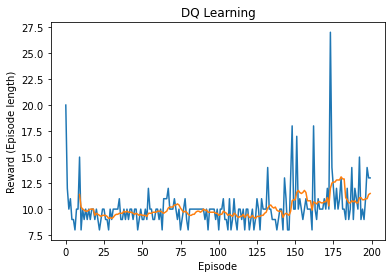

ep0 r = 13.0 t = 0.6
episode 0 reward 13.0 elapsed time [sec]: 0.6
ep1 r = 9.0 t = 0.46
episode 1 reward 9.0 elapsed time [sec]: 0.46
ep2 r = 13.0 t = 0.61
episode 2 reward 13.0 elapsed time [sec]: 0.61
ep3 r = 9.0 t = 0.42
episode 3 reward 9.0 elapsed time [sec]: 0.42
ep4 r = 8.0 t = 0.42
episode 4 reward 8.0 elapsed time [sec]: 0.42
ep5 r = 12.0 t = 0.59
episode 5 reward 12.0 elapsed time [sec]: 0.59
ep6 r = 9.0 t = 0.47
episode 6 reward 9.0 elapsed time [sec]: 0.47
ep7 r = 12.0 t = 0.6
episode 7 reward 12.0 elapsed time [sec]: 0.6
ep8 r = 9.0 t = 0.49
episode 8 reward 9.0 elapsed time [sec]: 0.49
ep9 r = 11.0 t = 0.62
episode 9 reward 11.0 elapsed time [sec]: 0.62


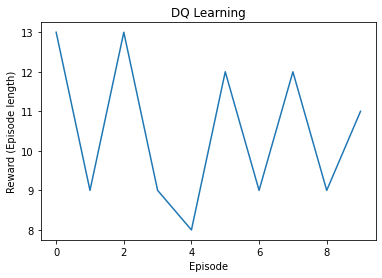

In [85]:
# def dq():
name = 'DQ Learning'

plot = True
max_steps = 500
total_episodes = 200

learning_parameters = {
    'learning_rate': 0.01, #0.001
    'gamma': 0.99, # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)
    'memory_capacity' : 20000
}

exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 1, ###
    'min_epsilon': 0.01,
    'decay_rate': 0.95 #0.05 # smaller decay rate, more exploration
}

# env = gym.make('CartPole-v1')
dq_agent = DQ_Agent(env, name, learning_parameters, exploration_parameters)

try:
    dq_agent.dq_learning(plot, max_steps, total_episodes)
    env.close()
except KeyboardInterrupt:
    env.close()
    print('closed env...')

pickle_data('dqlearning', dq_agent.q_network, dq_agent.episode_rewards)

# input('press to continue to play()')

try:
    dq_agent.play(10)
    env.close()
except KeyboardInterrupt:
    env.close()
    print('closed env...')

# dq()

## y = reward + (1-done) * gamma * max(Q(s', a'; theta)) + done * -10

ep0 epsilon = 1.0 r = 12 t = 0.0
ep10 epsilon = 0.01 r = 31 t = 5.19
ep20 epsilon = 0.01 r = 46 t = 7.82
ep30 epsilon = 0.01 r = 40 t = 7.03
ep40 epsilon = 0.01 r = 37 t = 6.62
ep50 epsilon = 0.01 r = 46 t = 7.7
ep60 epsilon = 0.01 r = 38 t = 6.48
ep70 epsilon = 0.01 r = 39 t = 6.98
ep80 epsilon = 0.01 r = 33 t = 5.85
ep90 epsilon = 0.01 r = 11 t = 1.89
ep100 epsilon = 0.01 r = 13 t = 2.32
ep110 epsilon = 0.01 r = 31 t = 5.75
ep120 epsilon = 0.01 r = 10 t = 1.72
ep130 epsilon = 0.01 r = 28 t = 4.91
ep140 epsilon = 0.01 r = 33 t = 6.03
ep150 epsilon = 0.01 r = 11 t = 2.0
ep160 epsilon = 0.01 r = 14 t = 2.5
ep170 epsilon = 0.01 r = 25 t = 4.79
ep180 epsilon = 0.01 r = 11 t = 1.85
ep190 epsilon = 0.01 r = 27 t = 4.72


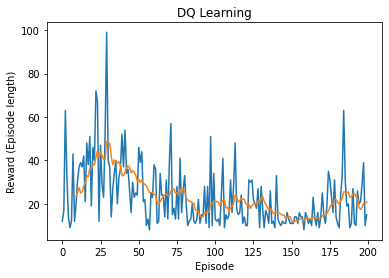

ep0 r = 21.0 t = 0.9
episode 0 reward 21.0 elapsed time [sec]: 0.9
ep1 r = 12.0 t = 0.53
episode 1 reward 12.0 elapsed time [sec]: 0.53
ep2 r = 11.0 t = 0.52
episode 2 reward 11.0 elapsed time [sec]: 0.52
ep3 r = 14.0 t = 0.63
episode 3 reward 14.0 elapsed time [sec]: 0.63
ep4 r = 8.0 t = 0.39
episode 4 reward 8.0 elapsed time [sec]: 0.39
ep5 r = 10.0 t = 0.49
episode 5 reward 10.0 elapsed time [sec]: 0.49
ep6 r = 9.0 t = 0.45
episode 6 reward 9.0 elapsed time [sec]: 0.45
ep7 r = 8.0 t = 0.4
episode 7 reward 8.0 elapsed time [sec]: 0.4
ep8 r = 22.0 t = 1.05
episode 8 reward 22.0 elapsed time [sec]: 1.05
ep9 r = 18.0 t = 0.87
episode 9 reward 18.0 elapsed time [sec]: 0.87


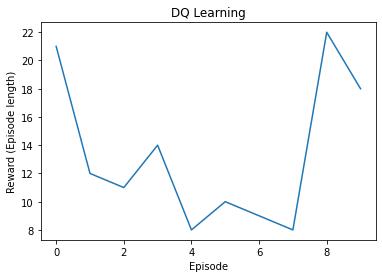

In [87]:
# def dq():
name = 'DQ Learning'

plot = True
max_steps = 500
total_episodes = 200

learning_parameters = {
    'learning_rate': 0.01, #0.001
    'gamma': 0.99, # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)
    'memory_capacity' : 20000
}

exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 1, ###
    'min_epsilon': 0.01,
    'decay_rate': 0.95 #0.05 # smaller decay rate, more exploration
}

# env = gym.make('CartPole-v1')
dq_agent = DQ_Agent(env, name, learning_parameters, exploration_parameters)

try:
    dq_agent.dq_learning(plot, max_steps, total_episodes)
    env.close()
except KeyboardInterrupt:
    env.close()
    print('closed env...')

pickle_data('dqlearning', dq_agent.q_network, dq_agent.episode_rewards)

# input('press to continue to play()')

try:
    dq_agent.play(10)
    env.close()
except KeyboardInterrupt:
    env.close()
    print('closed env...')

# dq()

## y = (1-done) * (reward + gamma * max(new_targets_i)) + done * -reward

ep0 epsilon = 1.0 r = 22 t = 0.0
ep10 epsilon = 0.01 r = 40 t = 6.98
ep20 epsilon = 0.01 r = 13 t = 2.17
ep30 epsilon = 0.01 r = 22 t = 3.83
ep40 epsilon = 0.01 r = 94 t = 15.64
ep50 epsilon = 0.01 r = 20 t = 3.33
ep60 epsilon = 0.01 r = 30 t = 5.03
ep70 epsilon = 0.01 r = 12 t = 2.12
ep80 epsilon = 0.01 r = 13 t = 2.25
ep90 epsilon = 0.01 r = 35 t = 6.32
ep100 epsilon = 0.01 r = 11 t = 1.88
ep110 epsilon = 0.01 r = 18 t = 3.05
ep120 epsilon = 0.01 r = 35 t = 6.16
ep130 epsilon = 0.01 r = 9 t = 1.61
ep140 epsilon = 0.01 r = 78 t = 13.77
ep150 epsilon = 0.01 r = 14 t = 2.51
ep160 epsilon = 0.01 r = 20 t = 3.48
ep170 epsilon = 0.01 r = 33 t = 5.64
ep180 epsilon = 0.01 r = 22 t = 3.79
ep190 epsilon = 0.01 r = 21 t = 3.71


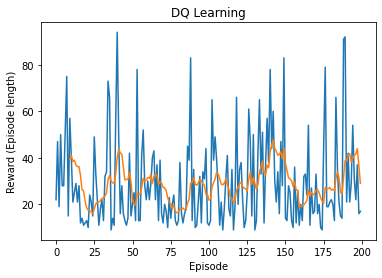

ep0 r = 8.0 t = 0.36
episode 0 reward 8.0 elapsed time [sec]: 0.36
ep1 r = 14.0 t = 0.6
episode 1 reward 14.0 elapsed time [sec]: 0.6
ep2 r = 12.0 t = 0.56
episode 2 reward 12.0 elapsed time [sec]: 0.56
ep3 r = 8.0 t = 0.37
episode 3 reward 8.0 elapsed time [sec]: 0.37
ep4 r = 9.0 t = 0.43
episode 4 reward 9.0 elapsed time [sec]: 0.43
ep5 r = 13.0 t = 0.58
episode 5 reward 13.0 elapsed time [sec]: 0.58
ep6 r = 8.0 t = 0.38
episode 6 reward 8.0 elapsed time [sec]: 0.38
ep7 r = 11.0 t = 0.51
episode 7 reward 11.0 elapsed time [sec]: 0.51
ep8 r = 9.0 t = 0.42
episode 8 reward 9.0 elapsed time [sec]: 0.42
ep9 r = 7.0 t = 0.34
episode 9 reward 7.0 elapsed time [sec]: 0.34


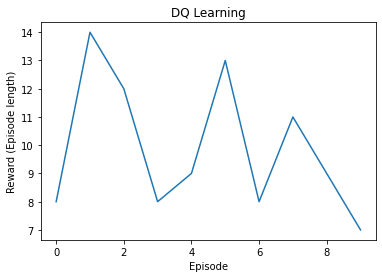

In [90]:
# def dq():
name = 'DQ Learning'

plot = True
max_steps = 500
total_episodes = 200

learning_parameters = {
    'learning_rate': 0.01, #0.001
    'gamma': 0.99, # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)
    'memory_capacity' : 20000
}

exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 1, ###
    'min_epsilon': 0.01,
    'decay_rate': 0.95 #0.05 # smaller decay rate, more exploration
}

# env = gym.make('CartPole-v1')
dq_agent = DQ_Agent(env, name, learning_parameters, exploration_parameters)

try:
    dq_agent.dq_learning(plot, max_steps, total_episodes)
    env.close()
except KeyboardInterrupt:
    env.close()
    print('closed env...')

pickle_data('dqlearning', dq_agent.q_network, dq_agent.episode_rewards)

# input('press to continue to play()')

try:
    dq_agent.play(10)
    env.close()
except KeyboardInterrupt:
    env.close()
    print('closed env...')

# dq()

## y = (1-done) * (reward + gamma * max(new_targets_i)) + done * -100

ep0 epsilon = 1.0 r = 41 t = 0.0
ep10 epsilon = 0.01 r = 9 t = 1.53
ep20 epsilon = 0.01 r = 10 t = 1.68
ep30 epsilon = 0.01 r = 10 t = 1.69
ep40 epsilon = 0.01 r = 10 t = 1.71
ep50 epsilon = 0.01 r = 11 t = 1.85
ep60 epsilon = 0.01 r = 145 t = 24.7
ep70 epsilon = 0.01 r = 50 t = 8.27
ep80 epsilon = 0.01 r = 13 t = 2.17
ep90 epsilon = 0.01 r = 10 t = 1.87
ep100 epsilon = 0.01 r = 11 t = 1.8
ep110 epsilon = 0.01 r = 10 t = 1.72
ep120 epsilon = 0.01 r = 10 t = 1.66
ep130 epsilon = 0.01 r = 9 t = 1.56
ep140 epsilon = 0.01 r = 13 t = 2.05
ep150 epsilon = 0.01 r = 22 t = 3.68
ep160 epsilon = 0.01 r = 165 t = 27.67
ep170 epsilon = 0.01 r = 21 t = 3.43
ep180 epsilon = 0.01 r = 20 t = 3.34
ep190 epsilon = 0.01 r = 11 t = 1.85


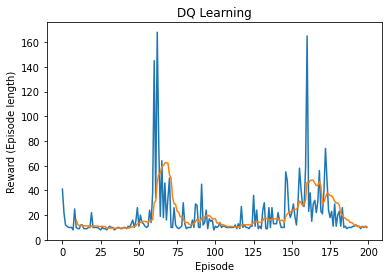

ep0 r = 9.0 t = 0.44
episode 0 reward 9.0 elapsed time [sec]: 0.44
ep1 r = 10.0 t = 0.47
episode 1 reward 10.0 elapsed time [sec]: 0.47
ep2 r = 8.0 t = 0.4
episode 2 reward 8.0 elapsed time [sec]: 0.4
ep3 r = 9.0 t = 0.45
episode 3 reward 9.0 elapsed time [sec]: 0.45
ep4 r = 10.0 t = 0.47
episode 4 reward 10.0 elapsed time [sec]: 0.47
ep5 r = 9.0 t = 0.43
episode 5 reward 9.0 elapsed time [sec]: 0.43
ep6 r = 8.0 t = 0.39
episode 6 reward 8.0 elapsed time [sec]: 0.39
ep7 r = 9.0 t = 0.42
episode 7 reward 9.0 elapsed time [sec]: 0.42
ep8 r = 9.0 t = 0.43
episode 8 reward 9.0 elapsed time [sec]: 0.43
ep9 r = 8.0 t = 0.38
episode 9 reward 8.0 elapsed time [sec]: 0.38


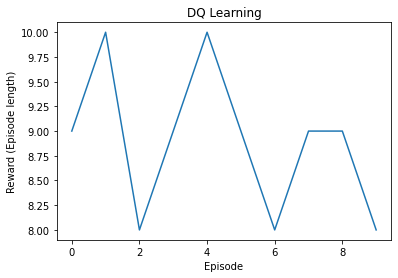

In [92]:
# def dq():
name = 'Deep Q Learning'

plot = True
max_steps = 500
total_episodes = 200

learning_parameters = {
    'learning_rate': 0.01, #0.001
    'gamma': 0.99, # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)
    'memory_capacity' : 20000
}

exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 1, ###
    'min_epsilon': 0.01,
    'decay_rate': 0.95 #0.05 # smaller decay rate, more exploration
}

# env = gym.make('CartPole-v1')
dq_agent = DQ_Agent(env, name, learning_parameters, exploration_parameters)

try:
    dq_agent.dq_learning(plot, max_steps, total_episodes)
    env.close()
except KeyboardInterrupt:
    env.close()
    print('closed env...')

pickle_data('dqlearning', dq_agent.q_network, dq_agent.episode_rewards)

# input('press to continue to play()')

try:
    dq_agent.play(10)
    env.close()
except KeyboardInterrupt:
    env.close()
    print('closed env...')

# dq()

# policy gradient REINFORCE

episode 0 reward 12.0 elapsed time [sec]: 0.9
episode 10 reward 28.0 elapsed time [sec]: 1.08
episode 20 reward 11.0 elapsed time [sec]: 0.5
episode 30 reward 7.0 elapsed time [sec]: 0.37
episode 40 reward 44.0 elapsed time [sec]: 1.59
episode 50 reward 8.0 elapsed time [sec]: 0.39
episode 60 reward 7.0 elapsed time [sec]: 0.34
episode 70 reward 7.0 elapsed time [sec]: 0.36
episode 80 reward 30.0 elapsed time [sec]: 1.32
episode 90 reward 7.0 elapsed time [sec]: 0.36
episode 100 reward 7.0 elapsed time [sec]: 0.35
episode 110 reward 8.0 elapsed time [sec]: 0.37
episode 120 reward 7.0 elapsed time [sec]: 0.35
episode 130 reward 8.0 elapsed time [sec]: 0.39
episode 140 reward 7.0 elapsed time [sec]: 0.35
episode 150 reward 7.0 elapsed time [sec]: 0.35
episode 160 reward 6.0 elapsed time [sec]: 0.33
episode 170 reward 7.0 elapsed time [sec]: 0.34
episode 180 reward 7.0 elapsed time [sec]: 0.38
episode 190 reward 7.0 elapsed time [sec]: 0.35


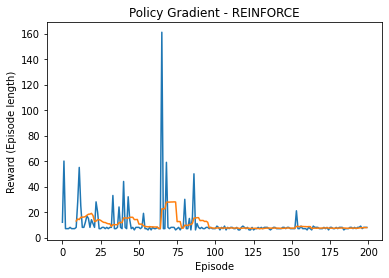

ep0 r = 9.0 t = 0.34
ep1 r = 8.0 t = 0.3
ep2 r = 9.0 t = 0.34
ep3 r = 9.0 t = 0.36
ep4 r = 8.0 t = 0.31
ep5 r = 7.0 t = 0.27
ep6 r = 8.0 t = 0.31
ep7 r = 8.0 t = 0.32
ep8 r = 9.0 t = 0.35
ep9 r = 8.0 t = 0.32


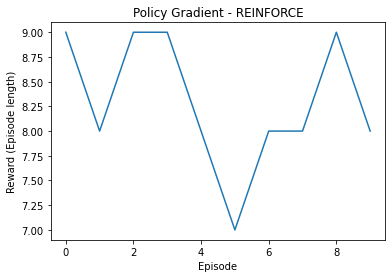

In [ ]:
class PG_agent:
    def __init__(self, env, name, learning_parameters, exploration_parameters):
        self.env = env
        self.name = name
        
        self.gamma = learning_parameters['gamma']
        self.epsilon = exploration_parameters['epsilon']
        self.decay_rate = exploration_parameters['decay_rate']
        self.max_epsilon = exploration_parameters['max_epsilon']
        self.min_epsilon = exploration_parameters['min_epsilon']
        self.learning_rate = learning_parameters['learning_rate']
        
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n

        self.policy_network = self.build_network()

        self.states = []
        self.actions = []
        self.rewards = []

    # approximate policy using Neural Network
    # state is input and probability of each action is output of network
    def build_network(self):
        model = models.Sequential()
        model.add(layers.Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(layers.Dense(16, activation='relu', kernel_initializer='glorot_uniform'))
        model.add(layers.Dense(self.action_size, activation='softmax', kernel_initializer='glorot_uniform'))
        model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=self.learning_rate))

        return model

    def get_action(self, state):
        action_probs = self.policy_network.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=action_probs)[0]

    def get_discounted_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        cumulated = 0
        for t in reversed(range(0, len(rewards))):
            cumulated = cumulated * self.gamma + rewards[t]
            discounted_rewards[t] = cumulated
        return discounted_rewards

    # update policy network every episode
    def pg_training(self):
        episode_length = len(self.states)

        discounted_rewards = self.get_discounted_rewards(self.rewards)
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)

        new_states = np.zeros((episode_length, self.state_size))
        new_actions = np.zeros((episode_length, self.action_size))

        for i in range(episode_length):
            new_states[i] = self.states[i]
            new_actions[i][self.actions[i]] = discounted_rewards[i]

        self.policy_network.fit(new_states, new_actions, epochs=1, verbose=0)

        self.states = []
        self.actions = []
        self.rewards = []

    def pg_learning(self, plot, max_steps, total_episodes):
        self.episode_rewards = np.zeros(total_episodes) 
        self.episode_epsilon = np.zeros(total_episodes)
        self.episode_last_state = np.zeros(total_episodes)

        scores = []
        episodes = []

        for episode_i in range(total_episodes):
            done = False
            score = 0
            state = env.reset()
            state = np.reshape(state, [1, self.state_size])
            start = time.time()
            while not done:

                action = self.get_action(state)
                new_state, reward, done, _ = env.step(action)
                new_state = np.reshape(new_state, [1, self.state_size])

                if done:
                    reward = -reward #-100
                else:
                    reward = reward

                self.states.append(state)
                self.rewards.append(reward)
                self.actions.append(action)

                score += reward
                state = new_state

                self.episode_rewards[episode_i] += reward            

                if done:
                    self.pg_training()

                    score = score if score == 500 else score + 100
                    scores.append(score)
                    episodes.append(episode_i)

                    # if the mean of scores of last 10 episode is bigger than 490
                    # stop training
                    if np.mean(scores[-min(10, len(scores)):]) > 490:
                        sys.exit()
            if plot and episode_i%10==0:
                print('episode {} reward {} elapsed time [sec]: {}'.format(episode_i, self.episode_rewards[episode_i], round((time.time() - start), 2)))
              
        plot_rewards(self)

    def play(self, total_episodes=10):
        self.episode_rewards = np.zeros(total_episodes) 
#         self.episode_epsilon = np.zeros(total_episodes)
#         self.episode_last_state = np.zeros(total_episodes)
        
        for episode_i in range(total_episodes):
            step = 0
            start = time.time()
        
            # self.env.render()
            state = self.env.reset()
            state = state.reshape([1, self.state_size]) # preprocessing
            action = self.get_action(state)
            new_state, reward, done, _ = self.env.step(action)
            
            while not done:
                # self.env.render()
                                
                action = self.get_action(state)
                new_state, reward, done, _ = self.env.step(action)

                state = new_state
                state = state.reshape([1, self.state_size]) # preprocessing
                
                self.episode_rewards[episode_i] += reward   
#                 print(reward)
                step += 1
                
                if done == True:
                    break
            
#             self.episode_rewards[episode_i] /= step # average the reward
#             self.episode_last_state[episode_i] = state # average the reward
            
            print('ep{} r = {} t = {}'.format(
                episode_i, self.episode_rewards[episode_i], round( (time.time() - start), 2)))
            
            if 100 <= step and 195 <= self.episode_rewards[episode_i]:
                print('solved!')
        plot_rewards(self) 

# def pg():
name = 'Policy Gradient - REINFORCE'
pg_agent = PG_agent(env, name, learning_parameters, exploration_parameters)

try:
    pg_agent.pg_learning(plot, max_steps, total_episodes)
    env.close()
except KeyboardInterrupt:
    env.close()
    print('closed env...')

pickle_data('pglearning', pg_agent.policy_network, pg_agent.episode_rewards)

# input('press to continue to play()')

try:
    pg_agent.play(10)
    env.close()
except KeyboardInterrupt:
    env.close()
    print('closed env...')
# pg()

# actor critic

running reward: 5.77 at episode 10
running reward: 13.22 at episode 20
running reward: 16.97 at episode 30
running reward: 20.38 at episode 40
running reward: 22.51 at episode 50
running reward: 42.91 at episode 60
running reward: 42.61 at episode 70
running reward: 35.32 at episode 80
running reward: 26.27 at episode 90
running reward: 23.00 at episode 100
running reward: 27.97 at episode 110
running reward: 33.97 at episode 120
running reward: 43.57 at episode 130
running reward: 64.23 at episode 140
running reward: 115.67 at episode 150
running reward: 200.97 at episode 160
Solved at episode 160!


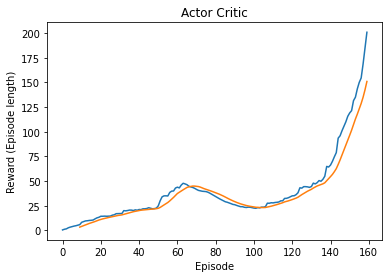

In [102]:
import keras

def ac():
    # Configuration parameters for the whole setup
    seed = 42
    gamma = 0.99  # Discount factor for past rewards
    max_steps_per_episode = 10000
    env = gym.make("CartPole-v1")  # Create the environment
    env.seed(seed)
    eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

    # Implement Actor Critic network

    num_inputs = 4
    num_actions = 2
    num_hidden = 128

    inputs = layers.Input(shape=(num_inputs,))
    common = layers.Dense(num_hidden, activation="relu")(inputs)
    action = layers.Dense(num_actions, activation="softmax")(common)
    critic = layers.Dense(1)(common)

    model = keras.Model(inputs=inputs, outputs=[action, critic])

    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    huber_loss = keras.losses.Huber()
    action_probs_history = []
    critic_value_history = []
    rewards_history = []
    running_reward = 0
    episode_count = 0
    episode_rewards = []

    while True:  # Run until solved
        state = env.reset()
        episode_reward = 0
        with tf.GradientTape() as tape:
            for timestep in range(1, max_steps_per_episode):
                # env.render(); Adding this line would show the attempts
                # of the agent in a pop up window.

                state = tf.convert_to_tensor(state)
                state = tf.expand_dims(state, 0)

                # Predict action probabilities and estimated future rewards
                # from environment state
                action_probs, critic_value = model(state)
                critic_value_history.append(critic_value[0, 0])

                # Sample action from action probability distribution
                action = np.random.choice(num_actions, p=np.squeeze(action_probs))
                action_probs_history.append(tf.math.log(action_probs[0, action]))

                # Apply the sampled action in our environment
                state, reward, done, _ = env.step(action)
                rewards_history.append(reward)
                episode_reward += reward

                if done:
                    break

            # Update running reward to check condition for solving
            running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

            # Calculate expected value from rewards
            # - At each timestep what was the total reward received after that timestep
            # - Rewards in the past are discounted by multiplying them with gamma
            # - These are the labels for our critic
            returns = []
            discounted_sum = 0
            for r in rewards_history[::-1]:
                discounted_sum = r + gamma * discounted_sum
                returns.insert(0, discounted_sum)

            # Normalize
            returns = np.array(returns)
            returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
            returns = returns.tolist()

            # Calculating loss values to update our network
            history = zip(action_probs_history, critic_value_history, returns)
            actor_losses = []
            critic_losses = []
            for log_prob, value, ret in history:
                # At this point in history, the critic estimated that we would get a
                # total reward = `value` in the future. We took an action with log probability
                # of `log_prob` and ended up recieving a total reward = `ret`.
                # The actor must be updated so that it predicts an action that leads to
                # high rewards (compared to critic's estimate) with high probability.
                diff = ret - value
                actor_losses.append(-log_prob * diff)  # actor loss

                # The critic must be updated so that it predicts a better estimate of
                # the future rewards.
                critic_losses.append(
                    huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
                )

            # Backpropagation
            loss_value = sum(actor_losses) + sum(critic_losses)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Clear the loss and reward history
            action_probs_history.clear()
            critic_value_history.clear()
            rewards_history.clear()

        # Log details
        episode_count += 1
        episode_rewards.append(running_reward)
        if episode_count % 10 == 0:
            template = "running reward: {:.2f} at episode {}"
            print(template.format(running_reward, episode_count))

        if running_reward > 195:  # Condition to consider the task solved
            print("Solved at episode {}!".format(episode_count))
            break

    plt.title('Actor Critic')
    plt.xlabel('Episode')
    plt.ylabel('Reward (Episode length)')
    plt.plot(episode_rewards, label='original')
    plt.plot(pd.Series(episode_rewards).rolling(window=10).mean(), label='average')
    plt.show()

    model.save('{}_network.h5'.format('aclearning'))

ac()